# Build a plot layer by layer

## Intro

Learn all five components of a layer

- data
- aesthetic mappings
- geom
- stat
- position adjustments

## Building a plot

Use dataset `mpg`

In [1]:
library(ggplot2)
library(repr)
options(repr.plot.width=3, repr.plot.height=2, repr.plot.res=180)

# multiplot function from Cookbook for R by Winston Chang
# modified by Yuanxing Cheng
# http://www.cookbook-r.com/Graphs/Multiple_graphs_on_one_page_(ggplot2)/
multiplot <- function(..., plotlist=NULL, file, ncol=1, layout=NULL, res=180, width=0) {
    library(grid)

    # Make a list from the ... arguments and plotlist
    plots <- c(list(...), plotlist)

    numPlots = length(plots)
    if (width>0){
        options(repr.plot.width=width, repr.plot.height=2*max(numPlots%/%ncol,1), repr.plot.res=res)
    } else{
        options(repr.plot.width=min(9,3*ncol), repr.plot.height=2*max(numPlots%/%ncol,1), repr.plot.res=res)   
    }

    # If layout is NULL, then use 'ncol' to determine layout
    if (is.null(layout)) {
        # Make the panel
        # ncol: Number of columns of plots
        # nrow: Number of rows needed, calculated from # of column
        layout <- matrix(
            seq(1, ncol * ceiling(numPlots/ncol)),
            ncol = ncol, nrow = ceiling(numPlots/ncol),
            byrow=TRUE # set byrow=TRUE will make the subplots listed by row
        )
    }

    if (numPlots==1) {
        print(plots[[1]])
    } else {
        # Set up the page
        grid.newpage()
        pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

        # Make each plot, in the correct location
        for (i in 1:numPlots) {
            # Get the i,j matrix positions of the regions that contain this subplot
            matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))
            print(
                plots[[i]],
                vp = viewport(
                    layout.pos.row = matchidx$row,
                    layout.pos.col = matchidx$col
                )
            )
        }
    }
}
myTheme = theme(
    plot.title = element_text(size = rel(0.5)), 
    axis.title = element_text(size = rel(0.8)), 
    legend.title = element_text(size = rel(0.8))
)

head(mpg)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


manufacturer,model,displ,year,cyl,trans,drv,cty,hwy,fl,class
audi,a4,1.8,1999,4,auto(l5),f,18,29,p,compact
audi,a4,1.8,1999,4,manual(m5),f,21,29,p,compact
audi,a4,2.0,2008,4,manual(m6),f,20,31,p,compact
audi,a4,2.0,2008,4,auto(av),f,21,30,p,compact
audi,a4,2.8,1999,6,auto(l5),f,16,26,p,compact
audi,a4,2.8,1999,6,manual(m5),f,18,26,p,compact


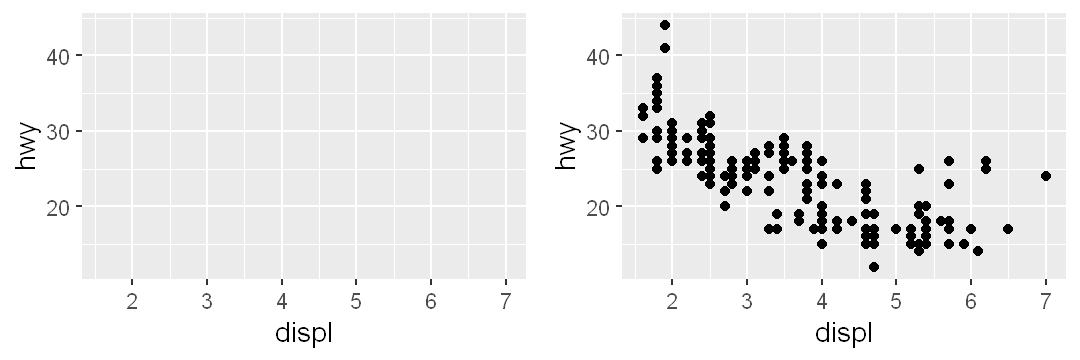

In [2]:
base <- ggplot(mpg, aes(displ, hwy))
p1 <- base + geom_point()
multiplot(base,p1,ncol=2)

Actually `geom_point()` calls function `layer()` as bellow:

```R
layer(
    mapping = NULL, 
    data = NULL,
    geom = "point", 
    stat = "identity",
    position = "identity"
)
```



- **mapping**: specify using the aes() function
- **data**: the plot dataset
- **geom**: the name of the geom
- **stat**: name of the statistical transform to use. Use `stat="identity"` to keep the data as it is
- **position**: the method used to adjust overlapping objects, see [11.7](#Position-adjustments)

Setting an argument to `NULL` will use the default set in `ggplot()`.

every geom has a default stat, and every stat a default geom, so only need to set one of the two.

Geoms also have additional arguments. All geoms take aesthetics as parameters. Or use `geom_params=ListOfParameters` to pass them.

Stats take additional parameters to specify the details of statistical transformation. Or use `geom_params=ListOfParameters` to pass them.

## Data

The textbook is using tidy data frames (with package `dplyr` and `tidyr`), with more operations available, but still with variables in the columns and observations in the rows.

I'll use native R to show the process in the book.

In [3]:
mod <- loess(hwy ~ displ, data = mpg)
# grid <- data_frame(displ = seq(min(mpg$displ), max(mpg$displ), length = 50))
grid <- data.frame(displ = seq(min(mpg$displ), max(mpg$displ), length = 50))
grid$hwy <- predict(mod, newdata = grid)
head(grid)

displ,hwy
1.600000,33.09286
1.710204,32.16100
1.820408,31.26635
1.930612,30.41403
2.040816,29.60168
2.151020,28.82979


In [19]:
std_resid <- resid(mod) / mod$s
# outlier <- dplyr::filter(mpg, abs(std_resid) > 2)
outlier <- mpg[abs(std_resid) > 2,]
head(outlier)

manufacturer,model,displ,year,cyl,trans,drv,cty,hwy,fl,class
chevrolet,corvette,5.7,1999,8,manual(m6),r,16,26,p,2seater
pontiac,grand prix,3.8,2008,6,auto(l4),f,18,28,r,midsize
pontiac,grand prix,5.3,2008,8,auto(s4),f,16,25,p,midsize
volkswagen,jetta,1.9,1999,4,manual(m5),f,33,44,d,compact
volkswagen,new beetle,1.9,1999,4,manual(m5),f,35,44,d,subcompact
volkswagen,new beetle,1.9,1999,4,auto(l4),f,29,41,d,subcompact


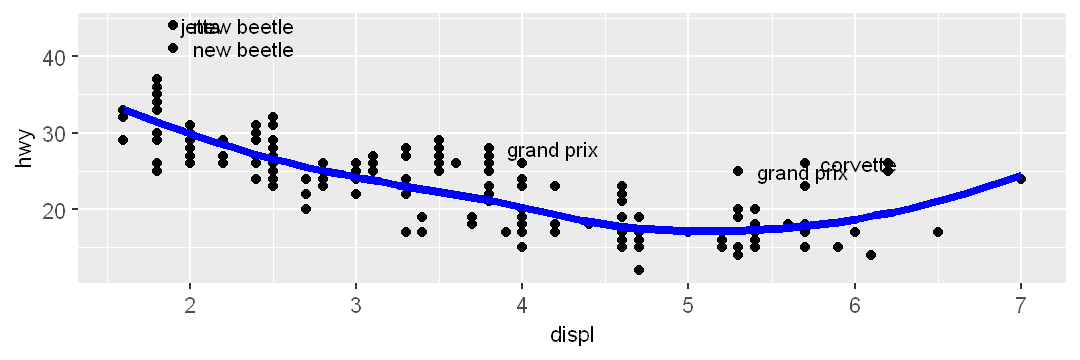

In [35]:
ggplot(mpg, aes(displ, hwy)) + 
geom_point() + 
geom_line(data = grid, colour = "blue", size = 1.5) + 
geom_text(data = outlier, aes(label = model),size = 3,hjust=-0.2) + myTheme

## Aesthetic mappings

`aes()` describe how variables are mapped to visual properties or aesthetics. Things like `aes(x = displ, y = hwy, colour = class)`, or just `aes(displ, hwy, colour = class)` will also do.

DO NOT do complex calculation in `aes()` otherwise every plot happens with that calculation. Instead you can move them to `dplyr::mutate()`

DO NOT refer to a variable with `$` in aes(), like `diamonds$carat`.

### Specifying the aesthetics in the plot vs. in the layers

Here're four different ways to specify the aesthetics.

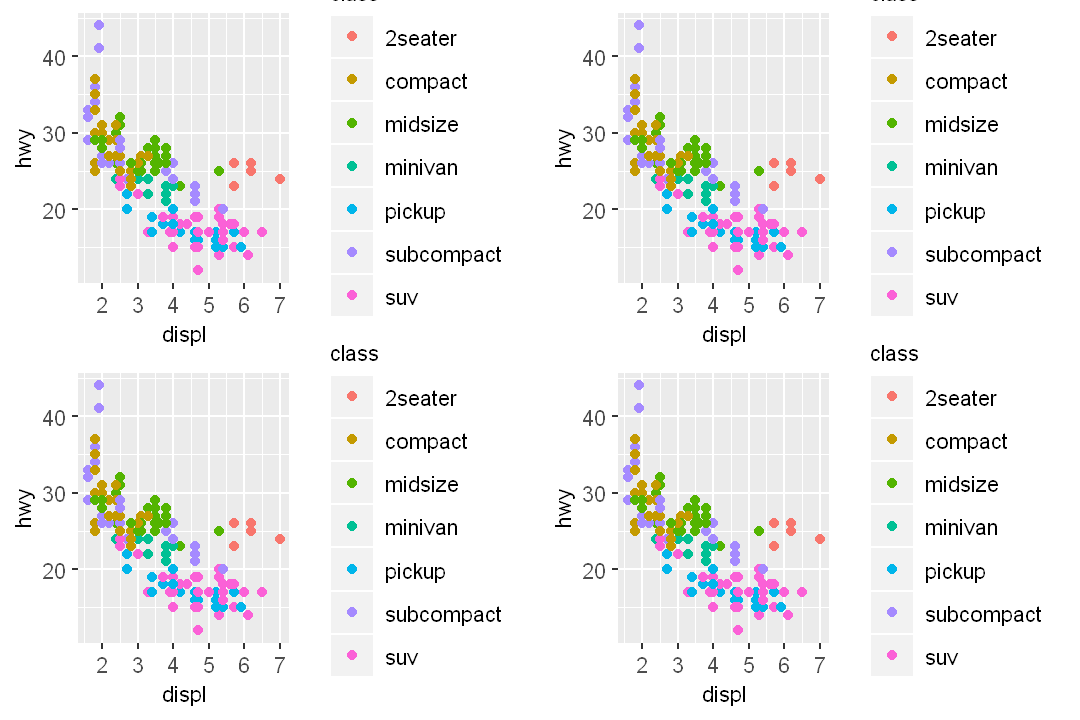

In [36]:
p1 <- ggplot(mpg, aes(displ, hwy, colour = class)) + 
geom_point() + myTheme
p2 <- ggplot(mpg, aes(displ, hwy)) + 
geom_point(aes(colour = class)) + myTheme
p3 <- ggplot(mpg, aes(displ)) + 
geom_point(aes(y = hwy, colour = class)) + myTheme
p4 <- ggplot(mpg) + 
geom_point(aes(displ, hwy, colour = class)) + myTheme

multiplot(p1,p2,p3,p4,ncol=2)

And different ways will cause differences.

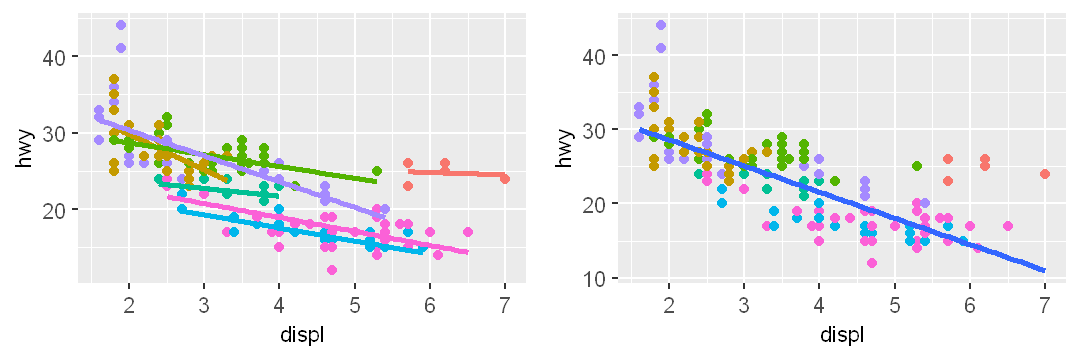

In [39]:
p1 <- ggplot(mpg, aes(displ, hwy, colour = class)) + 
geom_point() + 
geom_smooth(method = "lm", se = FALSE) +
theme(legend.position = "none")+myTheme
p2 <- ggplot(mpg, aes(displ, hwy)) + 
geom_point(aes(colour = class)) + 
geom_smooth(method = "lm", se = FALSE) + 
theme(legend.position = "none")+myTheme

multiplot(p1,p2,ncol=2)

### Setting vs. mapping

- map an aesthetic to a variable, like `aes(colour = cut)`
- set an aesthetic to a constant, like `aes(colour = "red")`
- to override the default size or colour, put the value outside, like `color="red"`
- to let it be governed by a variable, put the variable inside, like `aes(colour = cut)`

see the following

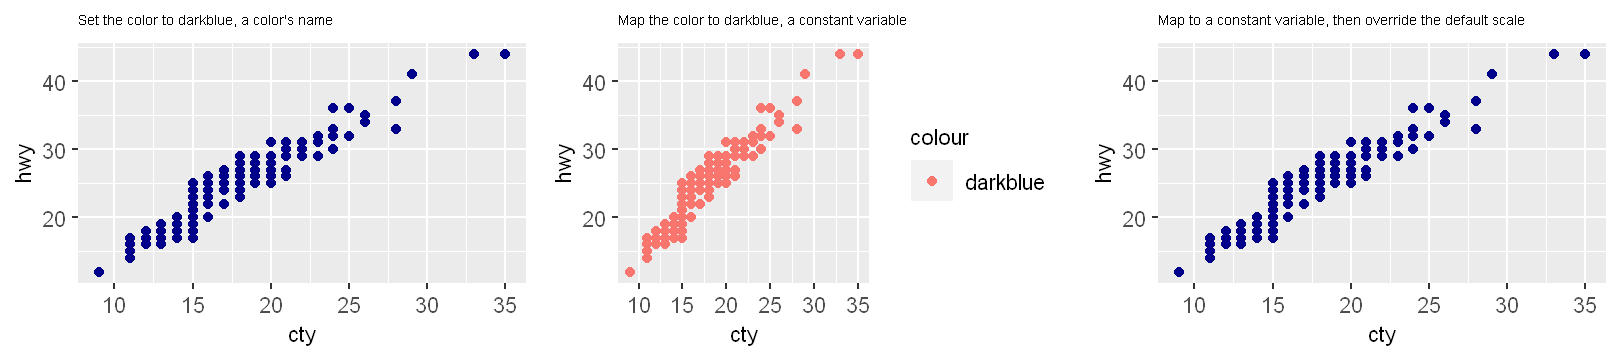

In [48]:
p1 <- ggplot(mpg, aes(cty, hwy)) + 
geom_point(colour = "darkblue") +
ggtitle("Set the color to darkblue, a color's name") + myTheme

p2 <- ggplot(mpg, aes(cty, hwy)) + 
geom_point(aes(colour = "darkblue")) +
ggtitle("Map the color to darkblue, a constant variable") + myTheme

p3 <- ggplot(mpg, aes(cty, hwy)) + 
geom_point(aes(colour = "darkblue")) + 
scale_colour_identity()+
ggtitle("Map to a constant variable, then override the default scale")+myTheme

multiplot(p1,p2,p3,ncol=3)

All three methods are useful in different ways. For the second one,

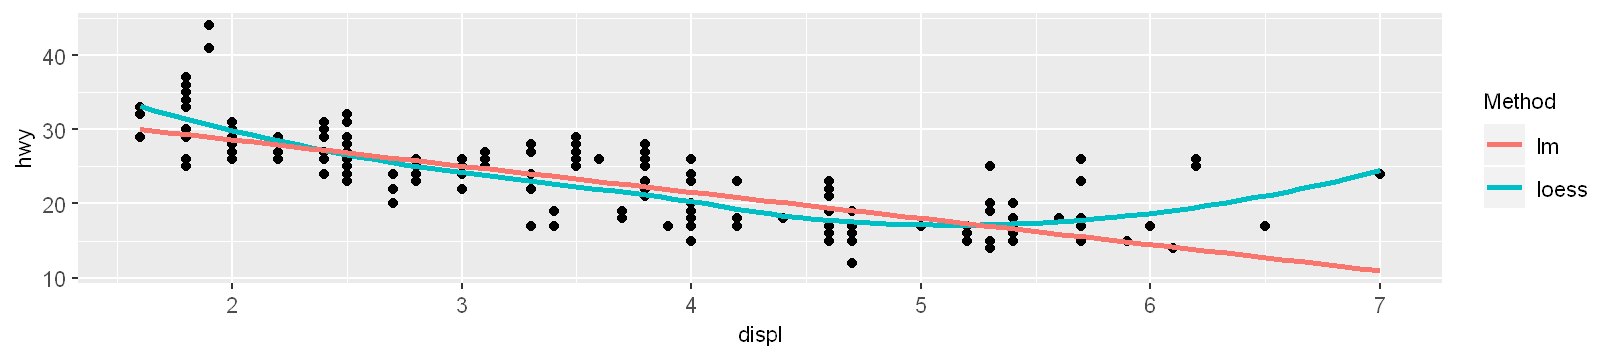

In [49]:
ggplot(mpg, aes(displ, hwy)) + 
geom_point() +
geom_smooth(aes(colour = "loess"), method = "loess", se = FALSE) + 
geom_smooth(aes(colour = "lm"), method = "lm", se = FALSE) +
labs(colour = "Method") + myTheme

name the color of different smoother using their method

## Geoms

- Graphical primitives:
    - `geom_blank()`: display nothing. Most useful for adjusting axes limits using data.
    - `geom_point()`: points.
    - `geom_path()`: paths.
    - `geom_ribbon()`: ribbons, a path with vertical thickness.
    - `geom_segment()`: a line segment, specified by start and end position.
    - `geom_rect()`: rectangles.
    - `geom_polygon()`: filled polygons.
    - `geom_text()`: text.
- One variable:
    - Discrete:
        - `geom_bar()`: display distribution of discrete variable.
    - Continuous
        - `geom_histogram()`: bin and count continuous variable, display with bars.
        - `geom_density()`: smoothed density estimate.
        - `geom_dotplot()`: stack individual points into a dot plot.
        - `geom_freqpoly()`: bin and count continuous variable, display with lines.
- Two variables:
    - Both continuous:
        - `geom_point()`: scatterplot.
        - `geom_quantile()`: smoothed quantile regression.
        - `geom_rug()`: marginal rug plots.
        - `geom_smooth()`: smoothed line of best fit.
        - `geom_text()`: text labels.
    - Show distribution:
        - `geom_bin2d()`: bin into rectangles and count.
        - `geom_density2d()`: smoothed 2d density estimate.
        - `geom_hex()`: bin into hexagons and count.
    - At least one discrete:
        - `geom_count()`: count number of point at distinct locations
        - `geom_jitter()`: randomly jitter overlapping points.
    - One continuous, one discrete:
        - `geom_bar(stat = "identity")`: a bar chart of precomputed summaries.
        - `geom_boxplot()`: boxplots.
        - `geom_violin()`: show density of values in each group.
    - One time, one continuous
        - `geom_area()`: area plot.
        - `geom_line()`: line plot.
        - `geom_step()`: step plot.
    - Display uncertainty:
        - `geom_crossbar()`: vertical bar with center.
        - `geom_errorbar()`: error bars.
        - `geom_linerange()`: vertical line.
        - `geom_pointrange()`: vertical line with center.
    - Spatial
        - `geom_map()`: fast version of geom_polygon() for map data.
- Three variables:
    - `geom_contour()`: contours.
    - `geom_tile()`: tile the plane with rectangles.
    - `geom_raster()`: fast version of geom_tile() for equal sized tiles.

## Stats

From geom function

- `stat_bin()`: `geom_bar()`, `geom_freqpoly()`, `geom_histogram()`
- `stat_bin2d()`: `geom_bin2d()`
- `stat_bindot()`: `geom_dotplot()`
- `stat_binhex()`: `geom_hex()`
- `stat_boxplot()`: `geom_boxplot()`
- `stat_contour()`: `geom_contour()`
- `stat_quantile()`: `geom_quantile()`
- `stat_smooth()`: `geom_smooth()`
- `stat_sum()`: `geom_count()`

Not from geom function

- `stat_ecdf()`: compute a empirical cumulative distribution plot.
- `stat_function()`: compute y values from a function of x values.
- `stat_summary()`: summarise y values at distinct x values.
- `stat_summary2d()`, `stat_summary_hex()`: summarise binned values.
- `stat_qq()`: perform calculations for a quantile-quantile plot.
- `stat_spoke()`: convert angle and radius to position.
- `stat_unique()`: remove duplicated rows.

Usage

- Add a `stat_()` function and override the default geom
- Add a `geom_()` function and override the default stat

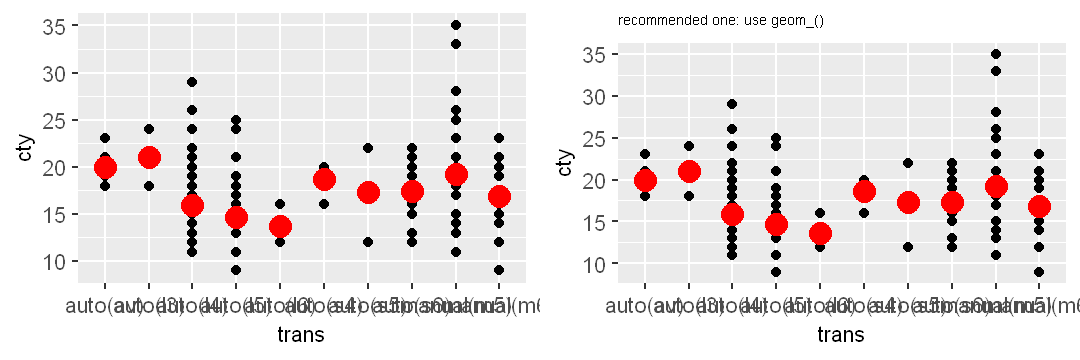

In [51]:
p1 <- ggplot(mpg, aes(trans, cty)) + 
geom_point() + 
stat_summary(geom = "point", fun.y = "mean", colour = "red", size = 4) + myTheme

p2 <- ggplot(mpg, aes(trans, cty)) + 
geom_point() + 
geom_point(stat = "summary", fun.y = "mean", colour = "red", size = 4) + myTheme +
ggtitle("recommended one: use geom_()")

multiplot(p1,p2,ncol=2)

method of the right figure is recommended.

### Generated variables

For example, `stat_bin()` will create

- `count`, the number of observations in each bin
- `density`, the density of observations in each bin (percentage of total / bar width)
- `x`, the centre of the bin

To refer to a generated variable, use `..` to surround the name.

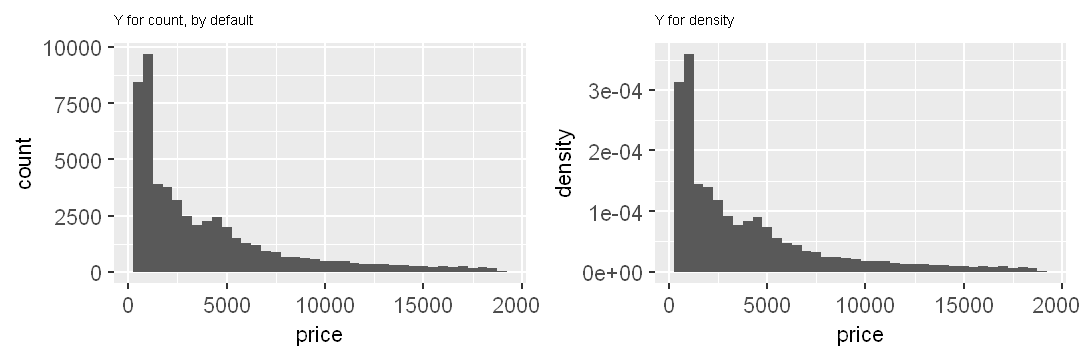

In [53]:
p1 <- ggplot(diamonds, aes(price)) + 
geom_histogram(binwidth = 500) + myTheme +
ggtitle("Y for count, by default")
p2 <- ggplot(diamonds, aes(price)) + 
geom_histogram(aes(y = ..density..), binwidth = 500) + myTheme +
ggtitle("Y for density")

multiplot(p1,p2,ncol=2)

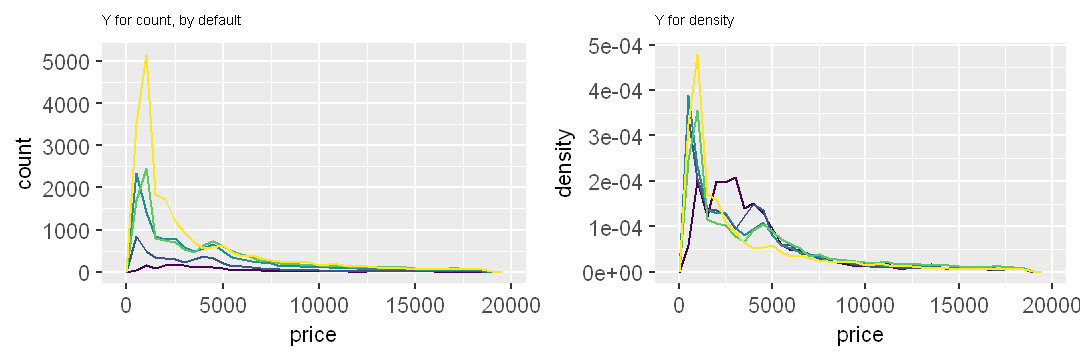

In [55]:
p1 <- ggplot(diamonds, aes(price, colour = cut)) + 
geom_freqpoly(binwidth = 500) +
theme(legend.position = "none") + myTheme +
ggtitle("Y for count, by default")

p2 <- ggplot(diamonds, aes(price, colour = cut)) + 
geom_freqpoly(aes(y = ..density..), binwidth = 500) + 
theme(legend.position = "none") + myTheme +
ggtitle("Y for density")

multiplot(p1,p2,ncol=2)

## Position adjustments

For bars:

- `position_stack()`: stack overlapping bars (or areas) on top of each other
- `position_fill()`: stack overlapping bars, scaling so the top is always at 1
- `position_dodge()`: place overlapping bars (or boxplots) side-by-side
- `position_identity()`: place overlapping bars at the same place

see the following

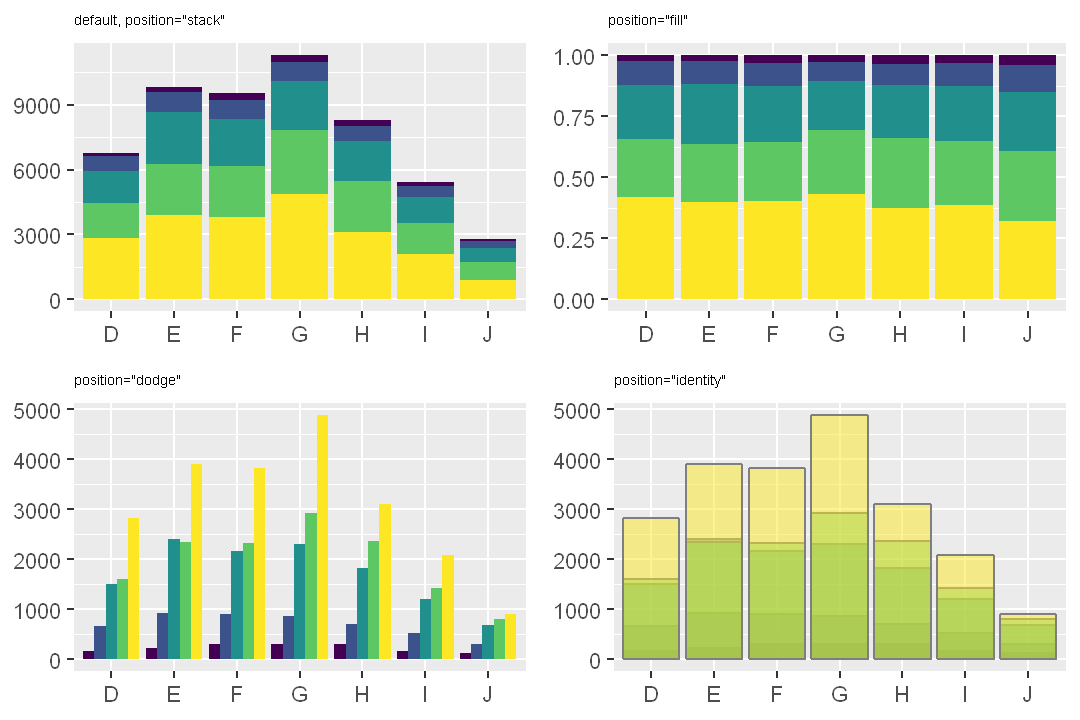

In [65]:
dplot <- ggplot(diamonds, aes(color, fill = cut)) +  xlab(NULL) + ylab(NULL) +
theme(legend.position = "none") + myTheme

p1 <- dplot + geom_bar() + ggtitle("default, position=\"stack\"")
p2 <- dplot + geom_bar(position = "fill") + ggtitle("position=\"fill\"")
p3 <- dplot + geom_bar(position = "dodge") + ggtitle("position=\"dodge\"")
p4 <- dplot + geom_bar(position = "identity", alpha=0.5, colour = "grey50") + ggtitle("position=\"identity\"")

multiplot(p1,p2,p3,p4,ncol=2)

Normally line plot doesn't need adjustment.

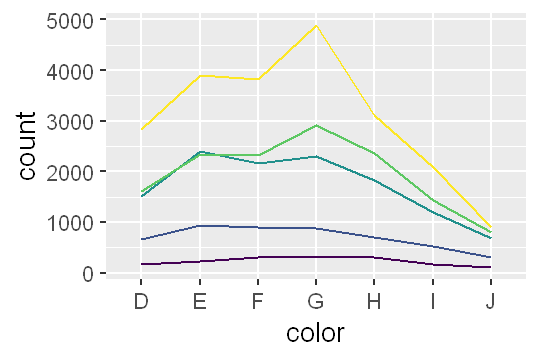

In [68]:
p1 <- ggplot(diamonds, aes(color, colour = cut)) + 
geom_line(aes(group = cut), stat = "count") +  
theme(legend.position = "none")

multiplot(p1)

For points plot:

- `position_nudge()`: move points by a fixed offset
- `position_jitter()`: add a little random noise to every position
- `position_jitterdodge()`: dodge points within groups, then add a little random noise

and add additional arguments in the call, like `geom_point(position = position_jitter(width = 1, height = 0.5))`

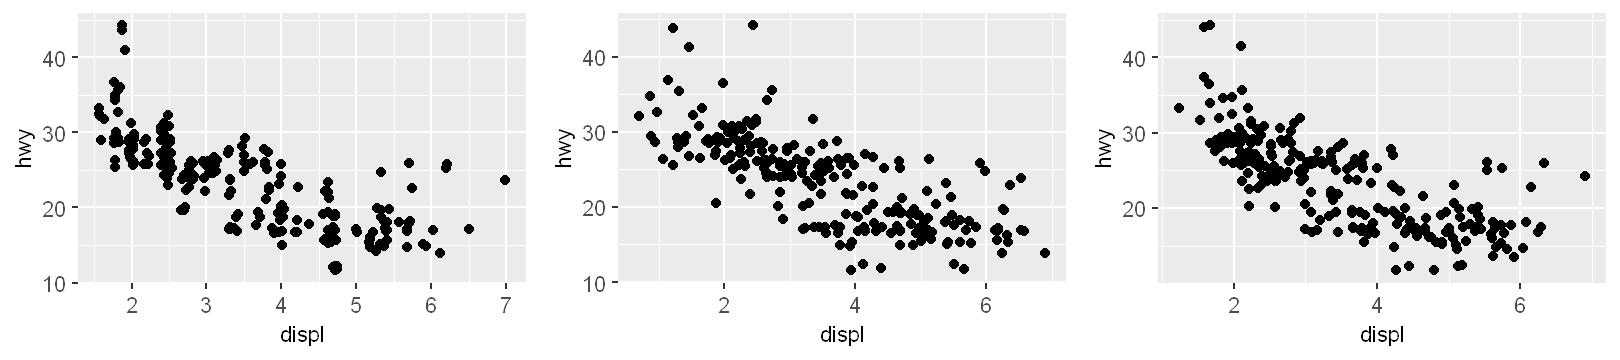

In [75]:
p1 <- ggplot(mpg, aes(displ, hwy)) + 
geom_point(position = "jitter") + myTheme
p2 <- ggplot(mpg, aes(displ, hwy)) + 
geom_point(position = position_jitter(width = 1, height = 0.5)) + myTheme
p3 <- ggplot(mpg, aes(displ, hwy)) + 
geom_jitter(width = 0.5, height = 0.5) + myTheme
multiplot(p1,p2,p3,ncol=3)